In [0]:
!pip install geffnet
!pip install timm

In [0]:
import geffnet
from torchsummary import summary
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sys
from timm.optim.radam import RAdam

In [0]:
torch.manual_seed(0)
use_GPU = torch.cuda.is_available()
device = torch.device("cuda" if use_GPU else "cpu")
if use_GPU:
    torch.cuda.manual_seed(0)
print("Using GPU: {}".format(use_GPU))

Using GPU: True


In [0]:
def ImageProcessing():
    transform = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224),
                                    transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

    train_dat = datasets.CIFAR10(root=sys.path[0] + "/data/CIFAR10", train=True, download=True, transform=transform)

    train_loader = DataLoader(train_dat, batch_size=32, shuffle=False, num_workers=2)

    test_dat = datasets.CIFAR10(root=sys.path[0] + '/data/CIFAR10', train=False, download=True, transform=transform)

    test_loader = torch.utils.data.DataLoader(test_dat, batch_size=1, shuffle=False, num_workers=2)

    return train_loader, test_loader

In [0]:
def training(model, train_loader, optimizer, criterion, epoch):
    training_loss = 0
    model.train()
    bi = 200

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss.backward()

        optimizer.step()

        training_loss += loss.item()

        if batch_idx % bi == bi-1:  # print every 2000 mini-batches
            print('[epoch: %d, batch: %5d] loss: %.4f' % (epoch + 1, batch_idx + 1, training_loss / bi))
            training_loss = 0.0


In [0]:
def testing(model, test_loader, criterion):
    test_loss = 0.0
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():

        for inputs, targets in test_loader:
          
            inputs = inputs.to(device)

            targets = targets.to(device)

            outputs = model(inputs)

            test_loss += criterion(outputs, targets).item()

            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == targets).sum().item()

            total += 1

    print("\nTest set: Average loss: {:.4f}, Accuracy: {:.4f}\n".format(test_loss / total,
                                                                        correct / len(test_loader.dataset)))
    return test_loss / total, correct / len(test_loader.dataset)

In [0]:
def predicition(md, loader):
    y_pred = []
    y_true = []

    with torch.no_grad():
        
        for inputs, targets in loader:

            inputs = inputs.to(device)

            targets = targets.to(device)

            outputs = model(inputs)

            test_loss += criterion(outputs, targets).item()

            _, predicted = torch.max(outputs.data, 1)

            y_pred.append(predicted)
            
            y_true.append(targets)

            correct += (predicted == targets).sum().item()

            total += 1

    print("\nTest set: Average loss: {:.4f}, Accuracy: {:.4f}\n".format(test_loss / total,
                                                                        correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), y_pred, y_true

In [0]:
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [0]:
def fine_tuning(model):

    epochs = 20
    lr = 0.0001

    test_acc = []
    test_loss = []

    model.to(device)

    summary(model,(3,224,224),batch_size=10)

    # optimizer = torch.optim.RMSprop(params_to_update, lr = 0.0001, weight_decay =1e-5)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.99, weight_decay=1e-5)
    # optimizer = torch.optim.SGD(params_to_update, lr=config["lr"], momentum=config["momentum"])

    # train_loader, test_loader = ImageProcessingForFolder("****************", 32, resolution, img_stats)
    
    # optimizer = torch.optim.Adam(model.parameters(),lr=lr,  eps=1e-5, weight_decay=1e-5)
    
    # reduce_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.6)
    reduce_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)

    train_loader, test_loader = ImageProcessing()

    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        
        print_learning_rate(optimizer,epoch+1)

        training(model, train_loader, optimizer, criterion, epoch)

        loss, acc = testing(model, test_loader, criterion)

        test_loss.append(loss)

        test_acc.append(acc)

        # adjust_learning_rate(0.0001, optimizer,epoch+1)

        reduce_lr.step(loss)


    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(list(range(1,epochs+1)), test_acc)
    ax1.set(xlabel='epochs', ylabel='test accuracy')
    ax2.plot(list(range(1,epochs+1)), test_loss)
    ax2.set(xlabel='epochs', ylabel='test loss')
    fig.tight_layout(pad=4.0)
    ax2.set_xticks(np.arange(1, epochs+1, step=1))
    ax1.set_xticks(np.arange(1, epochs+1, step=1))

    plt.show()
    
    return model


In [0]:
def adjust_learning_rate(lr, optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 0.97 every 2.4 epochs"""
    lr = lr * (0.9 ** (epoch // 2))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def print_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    for param_group in optimizer.param_groups:
        print("Epoch: [{}] Current learning rate (lr) = {}".format(
                                                    epoch, param_group['lr']))

In [0]:
def main(md):

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # classes = (
    # 'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    # 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    # 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    # 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    # 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    # 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    # 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    # 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    # 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    # 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    # 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    # 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    # 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    # 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    # 'worm')

    train_loader, test_loader = ImageProcessing()
    
    # print(len(classes))
    # imageshow(train_loader, classes)

    momentum = 0.9
    epochs = 20
    decay = 1e-5
    lr = 0.0001

    model = md.to(device)

    summary(model,(3,224,224),batch_size=10)

    criterion = nn.CrossEntropyLoss()
    
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = RAdam(model.parameters(),lr=lr,  eps=1e-5, weight_decay=decay)

    # reduce_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    # reduce_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

    for epoch in range(epochs):
        print_learning_rate(optimizer,epoch+1)
        training(model, train_loader, optimizer, criterion, epoch)
        loss,_ = testing(model, test_loader, criterion)
        adjust_learning_rate(lr, optimizer,epoch+1)
        # reduce_lr.step()

    PATH = './cifar_net.pth'
    torch.save(model.state_dict(), PATH)


In [0]:
# A formula differentiate the Swish operation
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i + i * sigmoid_i * (1 - sigmoid_i))

# MemoryEfficientSwish saves more memories than just using swish
# Save the input for back propagation, save more space for computing derivative
# https://medium.com/the-artificial-impostor/more-memory-efficient-swish-activation-function-e07c22c12a76
class EfficientSwish(nn.Module):
    def forward(self, input):
        # S = Swish.apply
        # return S(input)
        return input * torch.sigmoid(input)

['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_es', 'fbnetc_100', 'mixnet_l', 'mixnet_m', 'mixnet_s', 'mixnet_xl', 'mnasnet_a1', 'mnasnet_b1', 'mobilenetv3_large_100', 'mobilenetv3_rw', 'spnasnet_100', 'tf_efficientnet_b0', 'tf_efficientnet_b0_ap', 'tf_efficientnet_b0_ns', 'tf_efficientnet_b1', 'tf_efficientnet_b1_ap', 'tf_efficientnet_b1_ns', 'tf_efficientnet_b2', 'tf_efficientnet_b2_ap', 'tf_efficientnet_b2_ns', 'tf_efficientnet_b3', 'tf_efficientnet_b3_ap', 'tf_efficientnet_b3_ns', 'tf_efficientnet_b4', 'tf_efficientnet_b4_ap', 'tf_efficientnet_b4_ns', 'tf_efficientnet_b5', 'tf_efficientnet_b5_ap', 'tf_efficientnet_b5_ns', 'tf_efficientnet_b6', 'tf_efficientnet_b6_ap', 'tf_efficientnet_b6_ns', 'tf_efficientnet_b7', 'tf_efficientnet_b7_ap', 'tf_efficientnet_b7_ns', 'tf_efficientnet_b8', 'tf_efficientnet_b8_ap', 'tf_efficientnet_cc_b0_4e', 'tf_efficientnet_cc_b0_8e', 'tf_efficientnet_cc_b1_8e', 'tf_efficientnet_el', 'tf_efficientnet_em', 'tf

Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 32, 112, 112]             864
       BatchNorm2d-2         [10, 32, 112, 112]              64
          SwishJit-3         [10, 32, 112, 112]               0
            Conv2d-4         [10, 32, 112, 112]             288
       BatchNorm2d-5         [10, 32, 112, 112]              64
          SwishJit-6         [10, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [10, 32, 1, 1]               0
            Conv2d-8              [10, 8, 1, 1]             264
          SwishJit-9              [10, 8, 1, 1]               0
           Conv2d-10             [10, 32, 1, 1]             288
    SqueezeExcite-11         [10, 32, 112, 112]               0
           Conv2d-12         [10, 16, 112, 112]             512
      BatchNorm2d-13         [10, 16, 112, 112]              32
         Identity-14         [10, 16, 1

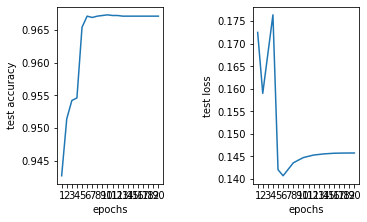

GenEfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishJit()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishJit()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishJit()
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity

In [0]:
print(torch.hub.list('rwightman/gen-efficientnet-pytorch'))

md = geffnet.create_model('efficientnet_b0',pretrained=True)

md.classifier = torch.nn.Linear(1280,10,bias=True)

# md.classifier = torch.nn.Sequential(
#             torch.nn.Linear(1280,128,bias=True),
#             nn.BatchNorm1d(num_features=128, eps=1e-5, momentum=1e-5),
#             EfficientSwish(),
#             nn.Dropout(0.5),

#             # torch.nn.Linear(512,128,bias=True),
#             # nn.BatchNorm1d(num_features=128, eps=1e-5, momentum=1e-5),
#             # EfficientSwish(),
#             # nn.Dropout(0.5),

#             torch.nn.Linear(128,10,bias=True),
#         )

fine_tuning(md)

# main(md)

In [0]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

test_pred = md.predict(x_test)
ax = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1),np.argmax(test_pred, axis=1)), cmap="YlGnBu",annot=True,fmt="d")

In [0]:
['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_es', 'fbnetc_100', 'mixnet_l', 'mixnet_m', 'mixnet_s', 'mixnet_xl', 'mnasnet_a1', 'mnasnet_b1', 'mobilenetv3_large_100', 'mobilenetv3_rw', 'spnasnet_100', 'tf_efficientnet_b0', 'tf_efficientnet_b0_ap', 'tf_efficientnet_b0_ns', 'tf_efficientnet_b1', 'tf_efficientnet_b1_ap', 'tf_efficientnet_b1_ns', 'tf_efficientnet_b2', 'tf_efficientnet_b2_ap', 'tf_efficientnet_b2_ns', 'tf_efficientnet_b3', 'tf_efficientnet_b3_ap', 'tf_efficientnet_b3_ns', 'tf_efficientnet_b4', 'tf_efficientnet_b4_ap', 'tf_efficientnet_b4_ns', 'tf_efficientnet_b5', 'tf_efficientnet_b5_ap', 'tf_efficientnet_b5_ns', 'tf_efficientnet_b6', 'tf_efficientnet_b6_ap', 'tf_efficientnet_b6_ns', 'tf_efficientnet_b7', 'tf_efficientnet_b7_ap', 'tf_efficientnet_b7_ns', 'tf_efficientnet_b8', 'tf_efficientnet_b8_ap', 'tf_efficientnet_cc_b0_4e', 'tf_efficientnet_cc_b0_8e', 'tf_efficientnet_cc_b1_8e', 'tf_efficientnet_el', 'tf_efficientnet_em', 'tf_efficientnet_es', 'tf_efficientnet_l2_ns', 'tf_efficientnet_l2_ns_475', 'tf_efficientnet_lite0', 'tf_efficientnet_lite1', 'tf_efficientnet_lite2', 'tf_efficientnet_lite3', 'tf_efficientnet_lite4', 'tf_mixnet_l', 'tf_mixnet_m', 'tf_mixnet_s', 'tf_mobilenetv3_large_075', 'tf_mobilenetv3_large_100', 'tf_mobilenetv3_large_minimal_100', 'tf_mobilenetv3_small_075', 'tf_mobilenetv3_small_100', 'tf_mobilenetv3_small_minimal_100']
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Files already downloaded and verified
Files already downloaded and verified
Epoch: [1] Current learning rate (lr) = 0.0001
[epoch: 1, batch:   200] loss: 1.3310
[epoch: 1, batch:   400] loss: 0.6354
[epoch: 1, batch:   600] loss: 0.4598
[epoch: 1, batch:   800] loss: 0.3937
[epoch: 1, batch:  1000] loss: 0.3280
[epoch: 1, batch:  1200] loss: 0.3127
[epoch: 1, batch:  1400] loss: 0.2587

Test set: Average loss: 0.8596, Accuracy: 0.9535

Epoch: [2] Current learning rate (lr) = 0.0001
[epoch: 2, batch:   200] loss: 0.2190
[epoch: 2, batch:   400] loss: 0.1774
[epoch: 2, batch:   600] loss: 0.1314
[epoch: 2, batch:   800] loss: 0.1113
[epoch: 2, batch:  1000] loss: 0.0891
[epoch: 2, batch:  1200] loss: 0.0843
[epoch: 2, batch:  1400] loss: 0.0788

Test set: Average loss: 0.4884, Accuracy: 0.9558

Epoch: [3] Current learning rate (lr) = 0.0001
[epoch: 3, batch:   200] loss: 0.0700
[epoch: 3, batch:   400] loss: 0.0511
[epoch: 3, batch:   600] loss: 0.0430
[epoch: 3, batch:   800] loss: 0.0382
[epoch: 3, batch:  1000] loss: 0.0363
[epoch: 3, batch:  1200] loss: 0.0404
[epoch: 3, batch:  1400] loss: 0.0333

Test set: Average loss: 0.2801, Accuracy: 0.9494

Epoch: [4] Current learning rate (lr) = 0.0001
[epoch: 4, batch:   200] loss: 0.0432
[epoch: 4, batch:   400] loss: 0.0293
[epoch: 4, batch:   600] loss: 0.0334
[epoch: 4, batch:   800] loss: 0.0340
[epoch: 4, batch:  1000] loss: 0.0378
[epoch: 4, batch:  1200] loss: 0.0325
[epoch: 4, batch:  1400] loss: 0.0356

Test set: Average loss: 0.1869, Accuracy: 0.9566

Epoch: [5] Current learning rate (lr) = 0.0001
[epoch: 5, batch:   200] loss: 0.0236
[epoch: 5, batch:   400] loss: 0.0266
[epoch: 5, batch:   600] loss: 0.0207
[epoch: 5, batch:   800] loss: 0.0208
[epoch: 5, batch:  1000] loss: 0.0176
[epoch: 5, batch:  1200] loss: 0.0133
[epoch: 5, batch:  1400] loss: 0.0202

Test set: Average loss: 0.1556, Accuracy: 0.9566

Epoch: [6] Current learning rate (lr) = 0.0001
[epoch: 6, batch:   200] loss: 0.0217
[epoch: 6, batch:   400] loss: 0.0257
[epoch: 6, batch:   600] loss: 0.0248
[epoch: 6, batch:   800] loss: 0.0187
[epoch: 6, batch:  1000] loss: 0.0171
[epoch: 6, batch:  1200] loss: 0.0158
[epoch: 6, batch:  1400] loss: 0.0147

Test set: Average loss: 0.1556, Accuracy: 0.9563

Epoch: [7] Current learning rate (lr) = 0.0001
[epoch: 7, batch:   200] loss: 0.0179
[epoch: 7, batch:   400] loss: 0.0222
[epoch: 7, batch:   600] loss: 0.0234
[epoch: 7, batch:   800] loss: 0.0187
[epoch: 7, batch:  1000] loss: 0.0210
[epoch: 7, batch:  1200] loss: 0.0185
[epoch: 7, batch:  1400] loss: 0.0135

Test set: Average loss: 0.1658, Accuracy: 0.9567

Epoch: [8] Current learning rate (lr) = 0.0001
[epoch: 8, batch:   200] loss: 0.0102
[epoch: 8, batch:   400] loss: 0.0127
[epoch: 8, batch:   600] loss: 0.0158
[epoch: 8, batch:   800] loss: 0.0245
[epoch: 8, batch:  1000] loss: 0.0228
[epoch: 8, batch:  1200] loss: 0.0216
[epoch: 8, batch:  1400] loss: 0.0157

Test set: Average loss: 0.1692, Accuracy: 0.9586

Epoch: [9] Current learning rate (lr) = 5e-05
[epoch: 9, batch:   200] loss: 0.0115
[epoch: 9, batch:   400] loss: 0.0089
[epoch: 9, batch:   600] loss: 0.0056
[epoch: 9, batch:   800] loss: 0.0075
[epoch: 9, batch:  1000] loss: 0.0051
[epoch: 9, batch:  1200] loss: 0.0035
[epoch: 9, batch:  1400] loss: 0.0025

Test set: Average loss: 0.1493, Accuracy: 0.9652

Epoch: [10] Current learning rate (lr) = 5e-05
[epoch: 10, batch:   200] loss: 0.0020
[epoch: 10, batch:   400] loss: 0.0025
[epoch: 10, batch:   600] loss: 0.0016
[epoch: 10, batch:   800] loss: 0.0017
[epoch: 10, batch:  1000] loss: 0.0011
[epoch: 10, batch:  1200] loss: 0.0017
[epoch: 10, batch:  1400] loss: 0.0007

Test set: Average loss: 0.1536, Accuracy: 0.9655

Epoch: [11] Current learning rate (lr) = 5e-05
[epoch: 11, batch:   200] loss: 0.0007
[epoch: 11, batch:   400] loss: 0.0007
[epoch: 11, batch:   600] loss: 0.0005
[epoch: 11, batch:   800] loss: 0.0006
[epoch: 11, batch:  1000] loss: 0.0006
[epoch: 11, batch:  1200] loss: 0.0005
[epoch: 11, batch:  1400] loss: 0.0003

Test set: Average loss: 0.1512, Accuracy: 0.9663

Epoch: [12] Current learning rate (lr) = 2.5e-05
[epoch: 12, batch:   200] loss: 0.0004
[epoch: 12, batch:   400] loss: 0.0004
[epoch: 12, batch:   600] loss: 0.0003
[epoch: 12, batch:   800] loss: 0.0003
[epoch: 12, batch:  1000] loss: 0.0003
[epoch: 12, batch:  1200] loss: 0.0003
[epoch: 12, batch:  1400] loss: 0.0002

Test set: Average loss: 0.1505, Accuracy: 0.9678

Epoch: [13] Current learning rate (lr) = 2.5e-05
[epoch: 13, batch:   200] loss: 0.0003
[epoch: 13, batch:   400] loss: 0.0003
[epoch: 13, batch:   600] loss: 0.0002
[epoch: 13, batch:   800] loss: 0.0002
[epoch: 13, batch:  1000] loss: 0.0002
[epoch: 13, batch:  1200] loss: 0.0002
[epoch: 13, batch:  1400] loss: 0.0002

Test set: Average loss: 0.1508, Accuracy: 0.9674

Epoch: [14] Current learning rate (lr) = 1.25e-05
[epoch: 14, batch:   200] loss: 0.0002
[epoch: 14, batch:   400] loss: 0.0002
[epoch: 14, batch:   600] loss: 0.0002
[epoch: 14, batch:   800] loss: 0.0002
[epoch: 14, batch:  1000] loss: 0.0002
[epoch: 14, batch:  1200] loss: 0.0002
[epoch: 14, batch:  1400] loss: 0.0001

Test set: Average loss: 0.1502, Accuracy: 0.9681

Epoch: [15] Current learning rate (lr) = 1.25e-05
[epoch: 15, batch:   200] loss: 0.0002
[epoch: 15, batch:   400] loss: 0.0002
[epoch: 15, batch:   600] loss: 0.0001
[epoch: 15, batch:   800] loss: 0.0001
[epoch: 15, batch:  1000] loss: 0.0002
[epoch: 15, batch:  1200] loss: 0.0001
[epoch: 15, batch:  1400] loss: 0.0001

Test set: Average loss: 0.1494, Accuracy: 0.9680

Epoch: [16] Current learning rate (lr) = 6.25e-06
[epoch: 16, batch:   200] loss: 0.0001
[epoch: 16, batch:   400] loss: 0.0001
[epoch: 16, batch:   600] loss: 0.0001
[epoch: 16, batch:   800] loss: 0.0001
[epoch: 16, batch:  1000] loss: 0.0001
[epoch: 16, batch:  1200] loss: 0.0001
[epoch: 16, batch:  1400] loss: 0.0001

Test set: Average loss: 0.1486, Accuracy: 0.9682

Epoch: [17] Current learning rate (lr) = 6.25e-06
[epoch: 17, batch:   200] loss: 0.0001
[epoch: 17, batch:   400] loss: 0.0001
[epoch: 17, batch:   600] loss: 0.0001
[epoch: 17, batch:   800] loss: 0.0001
[epoch: 17, batch:  1000] loss: 0.0001
[epoch: 17, batch:  1200] loss: 0.0001
[epoch: 17, batch:  1400] loss: 0.0001

Test set: Average loss: 0.1485, Accuracy: 0.9679

Epoch: [18] Current learning rate (lr) = 6.25e-06
[epoch: 18, batch:   200] loss: 0.0001
[epoch: 18, batch:   400] loss: 0.0001
[epoch: 18, batch:   600] loss: 0.0001
[epoch: 18, batch:   800] loss: 0.0001
[epoch: 18, batch:  1000] loss: 0.0001
[epoch: 18, batch:  1200] loss: 0.0001
[epoch: 18, batch:  1400] loss: 0.0001

Test set: Average loss: 0.1478, Accuracy: 0.9678

Epoch: [19] Current learning rate (lr) = 6.25e-06
[epoch: 19, batch:   200] loss: 0.0001
[epoch: 19, batch:   400] loss: 0.0001
[epoch: 19, batch:   600] loss: 0.0001
[epoch: 19, batch:   800] loss: 0.0001
[epoch: 19, batch:  1000] loss: 0.0001
[epoch: 19, batch:  1200] loss: 0.0001
[epoch: 19, batch:  1400] loss: 0.0001